# Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np

In [8]:
CM_SCORE = pd.read_csv('data/elix_score.csv',index_col=2)
DM = pd.read_csv('data/DMChartEvents.csv',usecols=["hadm_id", "subject_id", "itemid", "charttime","valuenum"])
DM = DM.sort_values(by=['charttime'])
Admissions = pd.read_csv('data/Admissions.csv',index_col=3)
Patients = pd.read_csv('data/Patients.csv',index_col=2)

In [9]:
hadm_id = []
subject_id = []
for index,row in DM.iterrows():
    if(row['hadm_id'] not in hadm_id):
        hadm_id.append(row['hadm_id'])
        subject_id.append(row['subject_id'])

In [10]:
d = {'hadm_id': hadm_id, 'subject_id': subject_id}
finalDF = pd.DataFrame(data=d)
finalDF['expire_flag'] = 0

In [11]:
for index,row in finalDF.iterrows():
    expire_flag = Admissions.loc[row['hadm_id'],'hospital_expire_flag']
    finalDF.at[index,'expire_flag'] = expire_flag

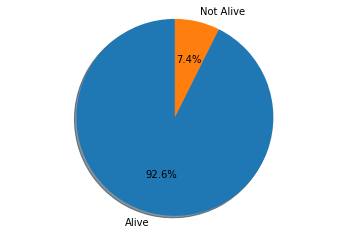

Alive:  6779
Not Alive:  539


In [12]:
alive = 0
dead = 0
for index,row in finalDF.iterrows():
    if(row['expire_flag'] == 1):
        dead = dead+1
    else:
        alive = alive+1
        
labels = 'Alive', 'Not Alive'
sizes = [alive,dead]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print("Alive: ", alive)
print("Not Alive: ", dead)

In [13]:
finalDF['admission_type'] = ''
for index,row in finalDF.iterrows():
    admission_type = Admissions.loc[row['hadm_id'],'admission_type']
    finalDF.at[index,'admission_type'] = admission_type

In [14]:
CM_SCORE

,Unnamed: 0,subject_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30
hadm_id,,,,,
100001,0,58526,5,5,5
100018,1,58128,18,26,36
100045,2,1569,22,29,38
100061,3,11728,5,7,8
100068,4,9889,7,9,10
...,...,...,...,...,...
199969,7949,6653,8,13,15
199883,7950,7029,0,-2,0
199979,7951,41115,5,8,11


In [15]:
finalDF['elix_score'] = 0
for index,row in finalDF.iterrows():
    elix_score = CM_SCORE.loc[row['hadm_id'],'elixhauser_vanwalraven']
    if(np.isnan(elix_score)):
        elix_score = 0
    finalDF.at[index,'elix_score'] = elix_score

In [17]:
finalDF['age'] = 0
for index,row in finalDF.iterrows():
    birth = Patients.loc[row['subject_id'],'dob']
    birth = datetime.strptime(birth, '%Y-%m-%d')
    birth_year = birth.year
    current = Admissions.loc[row['hadm_id'],'admittime']
    current = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
    current_year = current.year
    age = current_year-birth_year
    finalDF.at[index,'age'] = age

In [18]:
glucoseNumbers = {}
for index,row in DM.iterrows():
    glucoseNumbers.setdefault(row['hadm_id'], []).append(row['valuenum'])

In [19]:
finalDF['glucose'] = np.array
for index,row in finalDF.iterrows():
    glucose = glucoseNumbers[row['hadm_id']]
    finalDF.at[index,'glucose'] = glucose

In [20]:
finalDF

,hadm_id,subject_id,expire_flag,admission_type,elix_score,age,glucose
0,137275,9319,0,ELECTIVE,10,82,"[167.0, 157.0, 157.0, 143.0, 143.0, 113.0, 113..."
1,125380,31585,0,EMERGENCY,7,300,"[127.0, 127.0, 127.0, 113.0, 113.0, 113.0, 133..."
2,116534,46467,0,ELECTIVE,0,82,"[214.0, 178.0, 93.0, 150.0, 172.0, 169.0, 147...."
3,185232,46467,0,EMERGENCY,-1,82,"[184.0, 120.0, 132.0, 188.0, 118.0, 137.0, 139..."
4,112812,6155,0,EMERGENCY,9,60,"[63.0, 331.0, 351.0, 351.0, 52.0, 140.0, 220.0..."
...,...,...,...,...,...,...,...
7313,124466,17667,0,EMERGENCY,7,57,"[139.0, 106.0, 131.0, 127.0, 159.0, 131.0]"
7314,116670,15025,0,EMERGENCY,8,66,"[159.0, 141.0, 278.0, 293.0, 184.0, 152.0, 163..."
7315,197869,17667,0,EMERGENCY,17,57,"[96.0, 139.0, 97.0, 107.0, 114.0, 85.0, 146.0,..."
7316,183768,7632,0,EMERGENCY,26,65,"[71.0, 99.0, 74.0, 62.0, 174.0, 198.0, 281.0, ..."


In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le_admission_type = LabelEncoder()
finalDF['admission_type_encoded'] = le_admission_type.fit_transform(finalDF.admission_type)

In [23]:
glucose_count_A = {}
glucose_count_D = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    if(row['expire_flag'] == 0):
        glucose_count_A[index] = 0
        for num in glucose_list:
            glucose_count_A[index] += 1
    else:
        glucose_count_D[index] = 0
        for num in glucose_list:
            glucose_count_D[index] += 1

In [24]:
num_readings_A = {}
num_readings_D = {}

for key,value in glucose_count_A.items():
    if(value in num_readings_A):        
        num_readings_A[value] += 1
    else:
        num_readings_A[value] = 1
        
for key,value in glucose_count_D.items():
    if(value in num_readings_D):        
        num_readings_D[value] += 1
    else:
        num_readings_D[value] = 1

In [25]:
#N will change the max amount of numbers for visual purposes
N=60
num=np.arange(N)
occurA = []
occurD = []

for x in num:
    if x in num_readings_A:
        occurA.append(num_readings_A[x])
    else:
        occurA.append(0)

for x in num:
    if x in num_readings_D:
        occurD.append(num_readings_D[x])
    else:
        occurD.append(0)

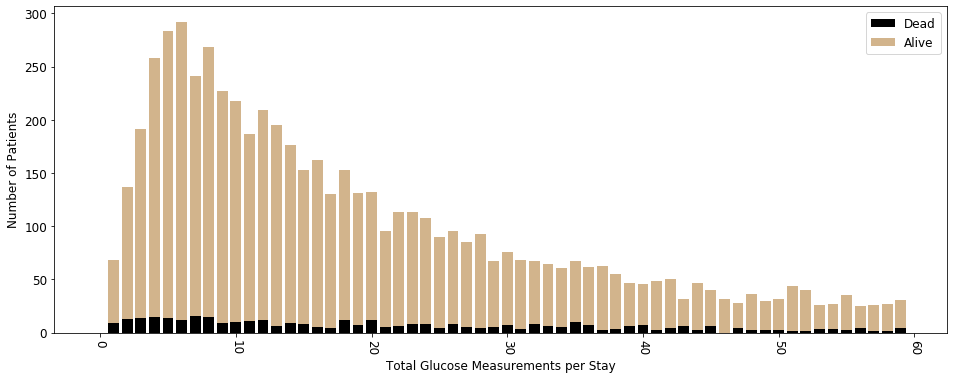

In [26]:
plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size':12})
plt.ylabel('Number of Patients')
plt.xlabel('Total Glucose Measurements per Stay')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.xticks(rotation=270)
p1 = plt.bar(num,occurD,color='black')
p2 = plt.bar(num,occurA,bottom=occurD,color='tan')
plt.legend((p1[0], p2[0]), ('Dead', 'Alive'))
#plt.savefig('glucose_distribution.png')
plt.show()

In [27]:
finalDF['glucose_readings'] = 0
glucose_dict = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_readings = len(glucose_list)
    finalDF.at[index,'glucose_readings'] = glucose_readings
    num = index
    if (len(glucose_list) < 30): 
        for glu in reversed(glucose_list):        
            glucose_dict.setdefault(num, []).append(glu)  
    else:
        for i in range(1,31):
            glucose_dict.setdefault(num, []).append(glucose_list[(len(glucose_list)-i)])

In [28]:
glucoseDF = pd.DataFrame.from_dict(glucose_dict, orient='index')

In [29]:
finalDF = finalDF.join(glucoseDF)

In [30]:
def Average(lst): 
    return sum(lst) / len(lst)

In [31]:
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_list = np.array(glucose_list)
    glucose_list = glucose_list[np.logical_not(np.isnan(glucose_list))]
    if(glucose_list.size<=0):
        #finalDF.loc[index,'mean'] = 0
        finalDF.loc[index,'range'] = 0
    else:
        glucose_list = glucose_list.astype(int)
        #mean = Average(glucose_list)
        maxval = max(glucose_list)
        minval = min(glucose_list)
        #finalDF.loc[index,'mean'] = int(mean)
        finalDF.loc[index,'range'] = (maxval - minval)

for index,row in finalDF.iterrows():
    if(row['range'] == 0):
        finalDF.drop([index])
    

In [32]:
finalDF = finalDF.fillna(0)

In [33]:
#Can determine how many patients are completely full with glucose readings
full = 0
not_full = 0
for index,row in finalDF.iterrows():
    if(row[17] == 0):
        not_full += 1
    else:
        full += 1
print('full: ',full)
print('not_full: ',not_full)
        

full:  3904
not_full:  3414


In [34]:
finalDF

,hadm_id,subject_id,expire_flag,admission_type,elix_score,age,glucose,admission_type_encoded,glucose_readings,0,...,21,22,23,24,25,26,27,28,29,range
0,137275,9319,0,ELECTIVE,10,82,"[167.0, 157.0, 157.0, 143.0, 143.0, 113.0, 113...",0,45,118.0,...,133.0,142.0,142.0,99.0,99.0,98.0,126.0,109.0,109.0,82.0
1,125380,31585,0,EMERGENCY,7,300,"[127.0, 127.0, 127.0, 113.0, 113.0, 113.0, 133...",1,10,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
2,116534,46467,0,ELECTIVE,0,82,"[214.0, 178.0, 93.0, 150.0, 172.0, 169.0, 147....",0,37,235.0,...,134.0,112.0,91.0,83.0,78.0,93.0,85.0,100.0,112.0,228.0
3,185232,46467,0,EMERGENCY,-1,82,"[184.0, 120.0, 132.0, 188.0, 118.0, 137.0, 139...",1,15,114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0
4,112812,6155,0,EMERGENCY,9,60,"[63.0, 331.0, 351.0, 351.0, 52.0, 140.0, 220.0...",1,30,301.0,...,483.0,251.0,220.0,140.0,52.0,351.0,351.0,331.0,63.0,457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7313,124466,17667,0,EMERGENCY,7,57,"[139.0, 106.0, 131.0, 127.0, 159.0, 131.0]",1,6,131.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
7314,116670,15025,0,EMERGENCY,8,66,"[159.0, 141.0, 278.0, 293.0, 184.0, 152.0, 163...",1,10,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0
7315,197869,17667,0,EMERGENCY,17,57,"[96.0, 139.0, 97.0, 107.0, 114.0, 85.0, 146.0,...",1,10,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
7316,183768,7632,0,EMERGENCY,26,65,"[71.0, 99.0, 74.0, 62.0, 174.0, 198.0, 281.0, ...",1,28,185.0,...,281.0,198.0,174.0,62.0,74.0,99.0,71.0,0.0,0.0,283.0


In [35]:
finalDF.to_csv('data/cnn_finalDF.csv', mode='w')

## RUN MODEL

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('../data/util/cnn_finalDF.csv',index_col=0)
df = df.drop(columns=['glucose'])
display(df.head(5))

,hadm_id,subject_id,expire_flag,admission_type,elix_score,age,admission_type_encoded,glucose_readings,0,1,...,21,22,23,24,25,26,27,28,29,range
0,137275,9319,0,ELECTIVE,10,82,0,45,118.0,97.0,...,133.0,142.0,142.0,99.0,99.0,98.0,126.0,109.0,109.0,82.0
1,125380,31585,0,EMERGENCY,7,300,1,10,118.0,127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
2,116534,46467,0,ELECTIVE,0,82,0,37,235.0,235.0,...,134.0,112.0,91.0,83.0,78.0,93.0,85.0,100.0,112.0,228.0
3,185232,46467,0,EMERGENCY,-1,82,1,15,114.0,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0
4,112812,6155,0,EMERGENCY,9,60,1,30,301.0,180.0,...,483.0,251.0,220.0,140.0,52.0,351.0,351.0,331.0,63.0,457.0


In [8]:
with open('../data/output/meta.json') as json_file:
    meta = json.load(json_file)

test_admission_ids = []

df_test_patients = pd.read_csv("../data/patients_test.csv")

for patient in df_test_patients.subject_id.tolist():
    test_admission_ids.append(meta[str(patient)]["admission_ids"][-1])

609


In [11]:
df_train = df[~df['hadm_id'].isin(test_admission_ids)]
df_test = df[df['hadm_id'].isin(test_admission_ids)]

print(len(df_test))

586


In [12]:
from sklearn.utils import resample
df_majority = df_train[df_train.expire_flag==0]
df_minority = df_train[df_train.expire_flag==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples=4000,     
                                 random_state=123) 

df_majority_downsampled = resample(df_majority, 
                                 replace=False, 
                                 n_samples=5000,     
                                 random_state=123) 

df_resampled = pd.concat([df_minority_upsampled, df_majority_downsampled])

In [13]:
pydf = df_resampled.values
print(pydf.shape)
#split features
X_train = pydf[:,4:39]
y_train = df_resampled['expire_flag']
#normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
#X = X.reshape((X.shape[0], X.shape[1], 1)) # undo for CNN needs to be reshaped

(9000, 39)


In [14]:
pydf = df_test.values
print(pydf.shape)
X_test = pydf[:,4:39]
y_test = df_test['expire_flag']
X_test = scaler.transform(X_test)

(586, 39)


In [15]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(9000, 35, 1)
(586, 35, 1)


## CNN

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=100, kernel_size=8, activation='relu', input_shape=(35, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

model.fit(X_train, y_train, epochs=75, batch_size=10)

Epoch 1/75
900/900 [==============================] - 2s 2ms/step - loss: 0.2184 - accuracy: 0.6403
Epoch 2/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1989 - accuracy: 0.6949
Epoch 3/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1893 - accuracy: 0.7141
Epoch 4/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1808 - accuracy: 0.7302
Epoch 5/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1718 - accuracy: 0.7454
Epoch 6/75
900/900 [==============================] - 2s 3ms/step - loss: 0.1663 - accuracy: 0.7571
Epoch 7/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1580 - accuracy: 0.7730
Epoch 8/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1514 - accuracy: 0.7820
Epoch 9/75
900/900 [==============================] - 2s 3ms/step - loss: 0.1460 - accuracy: 0.7940
Epoch 10/75
900/900 [==============================] - 2s 2ms/step - loss: 0.1387 - accuracy: 0.8064

In [92]:
print(model.summary())
y_pred_keras = model.predict(X_test).ravel()

from sklearn.metrics import confusion_matrix 
labels = ['Alive','Dead']
y_pred = model.predict(X_test)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
y_pred = y_pred.reshape(-1)
y_pred = y_pred.astype(np.int64)
y_test = y_test.astype(np.int64)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print(cm)

from sklearn.metrics import roc_auc_score
auc_micro = roc_auc_score(y_test, y_pred, average='micro', multi_class='raise')
print("AUC (micro):", auc_micro)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 28, 100)           900       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 100)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1400)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                70050     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 71,001
Trainable params: 71,001
Non-trainable params: 0
_________________________________________________________________
None
[[462  33]
 [113  26]]
AUC (micro): 0.5601918465227818


In [23]:
y_pred = model.predict(X_test)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
y_pred = y_pred.flatten()

y_score = model.predict(X_test)
y_score = y_score.flatten()

y_probs = []
for score in y_score:
    y_probs.append([1-score, score])

result_df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_test, 'y_score': y_probs, 'y_probscore': y_score})
result_df.to_csv("../data/results/cnn_results.csv", index=None)

print("*** DONE ***")

*** DONE ***
